Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


Load images

In [2]:
# Replace with your actual dataset path
DATASET_PATH = r"C:\Users\chris\Documents\ML_Gender_Classification\archive\gender_dataset"
IMG_SIZE = 224

images = []
labels = []

# Loop through the 'men' and 'women' folders
for label_name in ['men', 'women']:
    label_dir = os.path.join(DATASET_PATH, label_name)
    label = 0 if label_name == 'men' else 1  # 0: men, 1: women

    for file in os.listdir(label_dir):
        file_path = os.path.join(label_dir, file)

        # Skip non-image files
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        # Read and resize the image
        img = cv2.imread(file_path)
        if img is None:
            print(f"Skipping unreadable image: {file_path}")
            continue

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(img)
        labels.append(label)

# Convert to NumPy arrays and normalize
X = np.array(images, dtype='float32') / 255.0
y = np.array(labels)

# Shuffle the dataset
X, y = shuffle(X, y, random_state=42)

# Basic verification
print("Dataset loaded:", X.shape, y.shape)
print("Number of men:", np.sum(y == 0))
print("Number of women:", np.sum(y == 1))

# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training data:", X_train.shape, y_train.shape)
print("Testing data:", X_test.shape, y_test.shape)

Skipping unreadable image: C:\Users\chris\Documents\ML_Gender_Classification\archive\gender_dataset\men\104.jpg
Skipping unreadable image: C:\Users\chris\Documents\ML_Gender_Classification\archive\gender_dataset\men\533.jpg
Skipping unreadable image: C:\Users\chris\Documents\ML_Gender_Classification\archive\gender_dataset\men\788.jpg
Skipping unreadable image: C:\Users\chris\Documents\ML_Gender_Classification\archive\gender_dataset\women\245.jpg
Dataset loaded: (1664, 224, 224, 3) (1664,)
Number of men: 830
Number of women: 834
Training data: (1331, 224, 224, 3) (1331,)
Testing data: (333, 224, 224, 3) (333,)


Set up generators

In [3]:
# Image augmentation for training data only
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# No augmentation for test data, only rescaling
test_datagen = ImageDataGenerator()

batch_size = 32

# Apply data augmentation to training data
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=batch_size
)

# Only normalization for test data
val_generator = test_datagen.flow(
    X_test, y_test,
    batch_size=batch_size
)

Set up model architecture

In [4]:
base_model = MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
base_model.trainable = True  # Unfreeze entire model

# Freeze most layers except the top 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,618,945 (9.99 MB)

 Trainable params: 1,887,361 (7.20 MB)

 Non-trainable params: 731,584 (2.79 MB)

Training the model

In [5]:
# Compute class weights from the training labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

Class Weights: {0: np.float64(1.0022590361445782), 1: np.float64(0.9977511244377811)}


C:\Users\chris\Documents\ML_Gender_Classification\.venv1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.7000 - loss: 0.5440 - val_accuracy: 0.9069 - val_loss: 0.2261
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8856 - loss: 0.2547 - val_accuracy: 0.8619 - val_loss: 0.3378
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9212 - loss: 0.1786 - val_accuracy: 0.8348 - val_loss: 0.4887
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9619 - loss: 0.1045 - val_accuracy: 0.8198 - val_loss: 0.5736


Plot training and validation perfomance

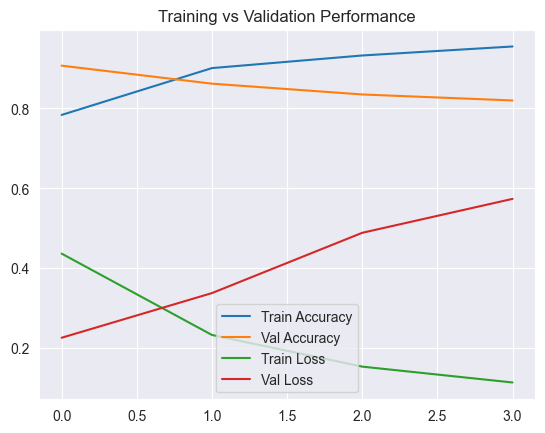

In [6]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training vs Validation Performance')
plt.show()

Evaluating and saving model

In [7]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Save the model in the modern Keras format
model.save("gender_classifier_model.keras")

11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9132 - loss: 0.2206
Validation Loss: 0.2261
Validation Accuracy: 0.9069


Use this cell to test the model

In [ ]:
from tensorflow.keras.models import load_model

def predict_gender(image_path, model_path="gender_classifier_model.keras"):
    model = load_model(model_path)

    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to read image at {image_path}")
        return

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)[0][0]
    label = "Female" if prediction > 0.5 else "Male"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    print(f"Predicted Gender: {label} (Confidence: {confidence:.2f})")

# Example usage
predict_gender(r"Insert_Path_To_Image_For_Testing")